In [1]:
import os
import cv2
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
titles={}
frames={}
audios={}
visuals={}
objects={}

In [3]:
import pickle
fol=os.listdir('/Users/macbookpro2017/Desktop/UnsupervisedVideoSummarization/video_ext_data')

data=[]
for videoID in fol:
    files=os.listdir('/Users/macbookpro2017/Desktop/UnsupervisedVideoSummarization/video_ext_data/'+videoID)

    for file in files:
        if('model' not in file):
            with open('/Users/macbookpro2017/Desktop/UnsupervisedVideoSummarization/video_ext_data/'+videoID+'/'+file,'rb') as f:
                data=pickle.load(f)
                if('title' in f.name):
                    titles[videoID]=(data)
                elif ('audio' in f.name):
                    audios[videoID]=(data)
                elif ('visual' in f.name):
                    visuals[videoID]=(data)
                elif ('objects' in f.name):
                    objects[videoID]=(data)


In [4]:
import pandas as pd
import os
import numpy as np
from math import ceil,floor

def calculate_mean_annotations(dir_anno, video_folder):
    # Load annotations
    df = pd.read_csv(dir_anno, sep='\t', header=None, names=['videoID', 'category', 'annotations'])

    # Get list of video IDs
    video_ids = [f for f in os.listdir(video_folder)]
    # Prepare result list
    results = {}

    # Calculate mean annotations for each video
    for videoid in video_ids:
        # Filter DataFrame for current video ID
        video_df = df[df['videoID'] == videoid]

        # If no annotations for this video, skip
        if video_df.empty:
            continue

        # Process each frame
        frame_means = []
        for _, row in video_df.iterrows():
            # Split the annotation string and convert to numeric
            frame_means.append([float(a) for a in row['annotations'].split(',')])
            
        # Calculate mean of all annotators for this frame
        frame_means=(np.array(frame_means).mean(axis=0)) #mean of all annotators for each frame
        
        # Round the mean to the nearest integer
        for index,frame in enumerate(frame_means):
            if abs(frame-ceil(frame))>0.5:
                frame_means[index]=floor(frame)
            else:
                frame_means[index]=ceil(frame)

        # Store in results
        results[videoid] = frame_means

    return results

# Example usage
dir_anno = 'datasets/ydata-tvsum50-v1_1/data/ydata-tvsum50-anno.tsv'
video_folder = '/Users/macbookpro2017/Desktop/UnsupervisedVideoSummarization/video_ext_data'
mean_annotations = calculate_mean_annotations(dir_anno, video_folder)


In [5]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode(objects_in_frame, unique_objects):
    # Handle None or empty values as 'no_object'
    object_array = ['no_object' if x is None or len(x) == 0 else x for x in objects_in_frame]

    # Reshape the array for OneHotEncoder
    object_array = np.array(object_array).reshape(-1, 1)

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False,dtype=float, categories=[unique_objects])

    # Fit and transform the data
    one_hot_encoded = encoder.fit_transform(object_array)
    return one_hot_encoded

def detectObjects(objects):
        
    # Here, taking the first detected object
    objects = [frame_objects[0] if frame_objects else 'None' for frame_objects in objects]

    # Generate unique objects and include 'no_object'
    unique_objects = sorted(set(objects + ['no_object']))

    # One-hot encoding of objects
    encoded_objects = one_hot_encode(objects, unique_objects)

    # Padding not required as one-hot encoding ensures consistent vector length
    
    return encoded_objects

Audio Dataset:

sound: Contains various sound descriptions like "snoring", "meowing", etc.
loudness: Represents the loudness of the sound, with values like "loud", "quiet", etc.
duration: Duration of the sound in seconds.
pitch: The pitch of the sound, noted as "high", "low", etc.


Objects Dataset:

object: Lists different objects such as "chair", "cat", etc.
color: The color of the object, like "red", "blue", etc.
size: Size of the object, categorized as "big", "small", etc.
material: Material of the object, such as "wood", "metal", etc.


Title Dataset:

title: Contains various titles like "King", "Doctor", etc.
gender: Gender associated with the title, such as "male", "female", "unisex".
age: Age range associated with the title, like "adult", "child", etc.
nationality: Nationality linked to the title, for example, "American", "Japanese", etc.


In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np

class MultimodalDataGenerator(Sequence):
    def __init__(self, audio_data, object_data, title_data, visual_data,annotations, batch_size):
        self.audio_data = audio_data
        self.object_data = object_data
        self.title_data = title_data
        self.annotations = annotations
        self.batch_size = batch_size
        self.visual_data=visual_data
        # Add more initialization if needed

    def __len__(self):
        return int(np.ceil(len(self.audio_data) / self.batch_size))

    def __getitem__(self, idx):
        # Get batches
        batch_audio = self.audio_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_object = self.object_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_title = self.title_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_visual = self.visual_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_annotations = self.annotations[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Pad sequences in the batch to the same length
        max_audio_len = max(len(seq) for seq in batch_audio)
        max_object_len = max(len(seq) for seq in batch_object)
        max_title_len = max(len(seq) for seq in batch_title)
        max_visual_len = max(len(seq) for seq in batch_visual)

        batch_audio = pad_sequences(batch_audio, maxlen=max_audio_len, padding='post', dtype='float32')
        batch_object = pad_sequences(batch_object, maxlen=max_object_len, padding='post', dtype='float32')
        batch_title = pad_sequences(batch_title, maxlen=max_title_len, padding='post', dtype='float32')
        batch_visual = pad_sequences(batch_visual, maxlen=max_visual_len, padding='post', dtype='float32')

        return {'audio_input': batch_audio, 'object_input': batch_object, 'title_input': batch_title, 'visual_input': batch_visual}, to_categorical(batch_annotations, num_classes=5)


def create_multimodal_network(audio_feature_dim, object_vocab_size, title_vocab_size,visual_feature_dim, embedding_dim):
    # Audio branch with LSTM
    audio_input = Input(shape=(None, audio_feature_dim), name='audio_input')
    audio_branch = LSTM(128, return_sequences=True)(audio_input)
    audio_branch = GlobalAveragePooling1D()(audio_branch)  # Aggregates over time
    
    visual_input = Input(shape=(None, visual_feature_dim), name='visual_input')
    visual_branch = LSTM(128, return_sequences=True)(visual_input)
    visual_branch = GlobalAveragePooling1D()(visual_branch)  # Aggregates over time

    # Object branch with embedding
    object_input = Input(shape=(None,), name='object_input')
    object_branch = Embedding(input_dim=object_vocab_size, output_dim=embedding_dim)(object_input)
    object_branch = GlobalMaxPooling1D()(object_branch)  # Aggregates over tokens

    # Title branch with embedding
    title_input = Input(shape=(None,), name='title_input')
    title_branch = Embedding(input_dim=title_vocab_size, output_dim=embedding_dim)(title_input)
    title_branch = GlobalMaxPooling1D()(title_branch)  # Aggregates over tokens

    # Combine all branches
    combined = concatenate([audio_branch, object_branch, title_branch,visual_branch])

    # Fully connected layers
    combined = Dense(256, activation='relu')(combined)
    combined = Dense(128, activation='relu')(combined)

    # Output layer for regression
    output = Dense(5, activation='softmax')(combined)

    # Create and compile the model
    model = Model(inputs=[audio_input, object_input, title_input,visual_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

In [7]:
def aggregate_to_fixed_size(features, target_size):
    """
    Aggregates features to a target size using averaging.

    :param features: A list or numpy array of features with variable size.
    :param target_size: The desired size of the output feature vector.
    :return: A numpy array of features with the target size.
    """
    # Convert to numpy array for easier manipulation
    features = np.array(features)

    # Check if the features are already at the target size
    if features.size == target_size:
        return features

    # If features are less than target size, pad with zeros
    if features.size < target_size:
        padding = np.zeros((target_size - features.size, features.shape[1]))
        return np.concatenate([features, padding])

    # If features are more than target size, compute the mean to reduce the size
    step = features.size / target_size
    aggregated_features = np.array([np.mean(features[int(i*step):int((i+1)*step)]) for i in range(target_size)])
    return aggregated_features

In [8]:

import numpy as np
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


combined_data_all = []
labels_all = []
# Combine all data
mean=[]

visual_all=[]
audio_all=[]
objects_all=[]
labels_all_for_each=[]
title_all=[]
print("Data preparation started")
for key, item in mean_annotations.items():
    title = titles[key]
    audio = audios[key]
    visual = visuals[key]
    padded_encoded_objects = detectObjects(objects[key])

    assert len(audio) == len(visual) == len(padded_encoded_objects) == len(item)
    
    combined_data = []
    for i, frame in enumerate(audio):
        combined_feature = np.concatenate([
            np.array(visual[i], dtype=float),
            np.array(audio[i], dtype=float),
            np.array(padded_encoded_objects[i], dtype=float),
            np.array(title, dtype=float).reshape(-1),
        ])    
        visual_all.append(np.array(visual[i], dtype=float))
        audio_all.append(np.array(audio[i], dtype=float))
        objects_all.append(np.array(padded_encoded_objects[i], dtype=float))
        title_all.append(np.array(title, dtype=float).reshape(-1))
        labels_all_for_each.append(item)
        combined_data.append(combined_feature)
        mean.append(len(combined_feature))
        
    labels_all.append(item)
    combined_data_all.append(np.array(combined_data))
print("Data preparation end")
# Assuming each frame's features are aggregated to a fixed size (feature_size)
feature_size=floor(np.mean(mean)+np.std(mean))


Data preparation started
Data preparation end


In [12]:
len(visual_all),len(audio_all),len(objects_all),len(title_all)

(143398, 143398, 143398, 143398)

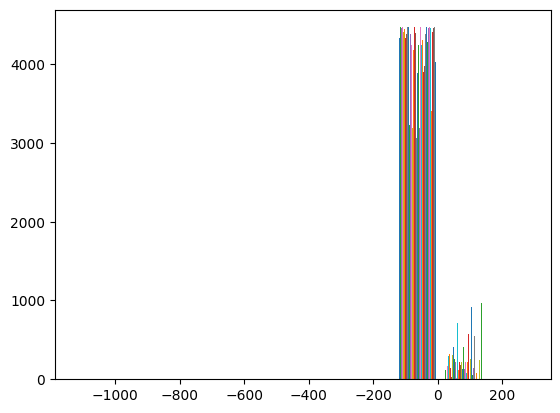
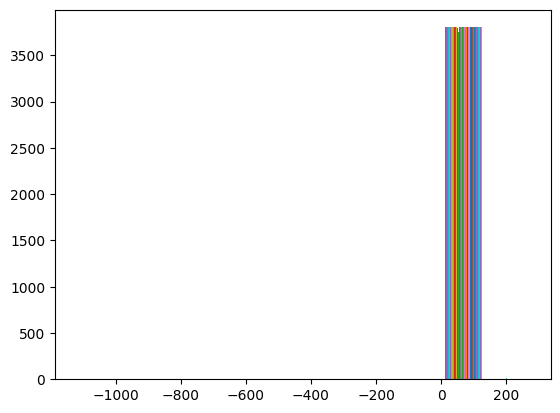

In [ ]:
from matplotlib import pyplot as plt
for v in combined_data_all:
    # plot all label for ech  video
    plt.figure()
    # plot the coount of label 
    plt.hist(v)
    plt.show()

In [13]:

X_train, X_test, y_train, y_test = train_test_split(combined_data_all, labels_all, test_size=0.6, random_state=42)

In [34]:
# Define model parameters
audio_feature_dim = 50  # Assuming each audio feature vector has 13 elements
object_vocab_size =len(objects_all)  # Size of your object vocabulary
title_vocab_size = len(title_all) # Size of your title vocabulary
visual_vocab_size = 50  # Size of your title vocabulary
embedding_dim = 50  # Embedding dimension for object and title tokens


print("Data preparation started")

# Create the model
model = create_multimodal_network(audio_feature_dim, object_vocab_size, title_vocab_size, visual_vocab_size,embedding_dim)

# Split data into training and validation sets
X_audio_train, X_audio_val, X_object_train, X_object_val, X_title_train, X_title_val, X_visual_train,X_visual_val,y_train, y_val = train_test_split(
    audio_all, objects_all, title_all,visual_all, labels_all_for_each, test_size=0.3, random_state=42)

# Prepare data generators
batch_size=int(32)
print(len(X_audio_train),len(X_object_train),len(X_title_train),len(X_visual_train),len(y_train))
train_generator = MultimodalDataGenerator(X_audio_train, X_object_train, X_title_train,X_visual_train, y_train, batch_size=batch_size)
val_generator = MultimodalDataGenerator(X_audio_val, X_object_val, X_title_val,X_visual_val ,y_val, batch_size=batch_size)

# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)

# Save the model
model.save('multimodal_model.h5')

Data preparation started
100378 100378 100378 100378 100378


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.

In [60]:
with open('NNmodel70.pkl', 'wb') as f:
    dump(model, f)

In [59]:
import numpy as np
from sklearn.metrics import accuracy_score

for video, labels in zip(X_test, y_test):
    predictions = []
    actual_labels = []
    for frame,label in zip(video,labels):
        # Aggregate frame features
        aggregated_features = aggregate_to_fixed_size(frame, feature_size)

        # Predict
        frame_prediction = model.predict(np.array([aggregated_features]),steps=None)
        predicted_class = np.argmax(frame_prediction, axis=1) + 1  # Adding 1 if class labels start from 1

        # print('Frames posibility:',frame_prediction)
        # print("Predicted Class:", predicted_class[0])
        # print(predicted_class, label)
        
        predictions.append(predicted_class)
        actual_labels.append(label)
        
    predictions2 = [int(p > 0.5) for p in predictions]  # Adjust the threshold as needed

    # Ensure labels are in a compatible format (e.g., convert to int if necessary)
    actual_labels2 = [int(label) for label in actual_labels]

    # Now, evaluate the predictions
    print(actual_labels2)
    print(predictions2)
    accuracy = accuracy_score(actual_labels2, predictions2)
    print(f'Accuracy: {accuracy}')
    break


1/1 [==============================] - 0s 51ms/step
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [52]:
prediction=[np.argmax(x, axis=1) + 1 for x in predictions] # Adding 1 if class labels start from 1
predictions2 = [int(p > 0.5) for p in prediction]  # Adjust the threshold as needed

# Ensure labels are in a compatible format (e.g., convert to int if necessary)
actual_labels2 = [int(label) for label in actual_labels]

# Now, evaluate the predictions
print(actual_labels2)
print(predictions2)
accuracy = accuracy_score(actual_labels, predictions2)
print(f'Accuracy: {accuracy}')

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 